Följer nedan webbaserad bok kapitel 4.7 för att med  Logistic Regression se om det är möjligt att förutsäga pris på Ethereum (krypto).

https://www.statlearning.com/

Via ett api på CoinGeckos kryptosida har jag laddat ner data från 2018 och framåt. Datat återfinns i csv-filen "sammanslagen_data.csv".

Importerar dom bibliotek som behövs.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)
from ISLP import confusion_table

In [117]:
# Sökvägen till CSV-fil
csv_fil_sökväg = "sammanslagen_data.csv"

# Läs in CSV-filen
crypto_data = pd.read_csv(csv_fil_sökväg)

# Visa de första raderna av DataFrame
crypto_data.head(10)


,Date,Price
0,2018-01-01,6345
1,2018-01-02,7155
2,2018-01-03,7879
3,2018-01-04,7959
4,2018-01-05,8199
5,2018-01-06,8583
6,2018-01-07,9267
7,2018-01-08,9723
8,2018-01-09,11216
9,2018-01-10,11023


In [118]:
# Skriv ut antalet rader i DataFrame
print("Antal rader i datasetet:", len(crypto_data))

Antal rader i datasetet: 1825


In [119]:
crypto_data.columns

Index(['Date', 'Price'], dtype='object')

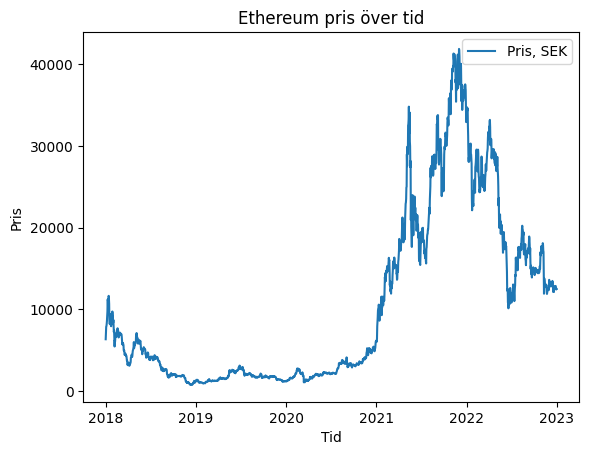

In [120]:
# Konvertera datumkolumnen till pandas datetime-objekt
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'])
# Plotta datan
plt.plot(crypto_data['Date'], crypto_data['Price'], label='Pris, SEK')
plt.xlabel('Tid')
plt.ylabel('Pris')
plt.title('Ethereum pris över tid')
plt.legend()
plt.show()

### Lägger till LAG1-5 för price och sparar ner som en ny CSV-fil

In [121]:
import pandas as pd

# Skapa en kopia av DataFrame
crypto_price_LAG = crypto_data.copy()

# Skapa LAG värden för Lag1 till Lag5 med shift
for lag in range(1, 6):
    crypto_price_LAG[f'Lag{lag}'] = crypto_price_LAG['Price'].shift(lag)

# Ta bort rader med NaN-värden (eftersom skiftet inte kan beräknas för de första några raderna)
crypto_price_LAG = crypto_price_LAG.dropna()

# Spara DataFrame till en ny CSV-fil
crypto_price_LAG.to_csv('LAG_on_crypto_price_market_subset.csv', index=False)


In [122]:
crypto_price_LAG.columns

Index(['Date', 'Price', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'], dtype='object')

In [123]:
crypto_price_LAG.head()

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5
5,2018-01-06,8583,8199.0,7959.0,7879.0,7155.0,6345.0
6,2018-01-07,9267,8583.0,8199.0,7959.0,7879.0,7155.0
7,2018-01-08,9723,9267.0,8583.0,8199.0,7959.0,7879.0
8,2018-01-09,11216,9723.0,9267.0,8583.0,8199.0,7959.0
9,2018-01-10,11023,11216.0,9723.0,9267.0,8583.0,8199.0


In [124]:
# Skriv ut antalet rader i DataFrame
print("Antal rader i datasetet:", len(crypto_price_LAG))

Antal rader i datasetet: 1820


Nedan .dtypes ger vilken datatyp varje kolumn i dataserien "crypto_price_LAG" har.

In [125]:
print(crypto_price_LAG.dtypes)

Date     datetime64[ns]
Price             int64
Lag1            float64
Lag2            float64
Lag3            float64
Lag4            float64
Lag5            float64
dtype: object


Metoden .corr() i nedan kodcell,  beräknar den parvisa korrelationen mellan kolumner. Som standard beräknar den Pearsons korrelationskoefficient, vilket mäter det linjära sambandet mellan två variabler. Resultatet är en korrelationsmatris där varje cell representerar korrelationskoefficienten mellan två kolumner. En korrelationskoefficient nära 1 indikerar en stark positiv korrelation, nära -1 indikerar en stark negativ korrelation och nära 0 indikerar liten till ingen linjär korrelation.

In [126]:
crypto_price_LAG.corr()

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5
Date,1.000000,0.695731,0.695750,0.695783,0.695832,0.695916,0.696048
Price,0.695731,1.000000,0.997979,0.996210,0.994364,0.992396,0.990308
Lag1,0.695750,0.997979,1.000000,0.997978,0.996210,0.994362,0.992389
Lag2,0.695783,0.996210,0.997978,1.000000,0.997978,0.996208,0.994356
Lag3,0.695832,0.994364,0.996210,0.997978,1.000000,0.997977,0.996203
Lag4,0.695916,0.992396,0.994362,0.996208,0.997977,1.000000,0.997976
Lag5,0.696048,0.990308,0.992389,0.994356,0.996203,0.997976,1.000000


Ovan resultat med korrelationsfaktorer nära 1 på samtliga parvisa korrelationer skulle innebära en stark positiv korrelation. Kan detta verkligen stämma undrar jag?

Nedan ville jag bara se om jag kunde få en bättre överblick genom att skapa en heatmap mellan korrelationsvärderna.

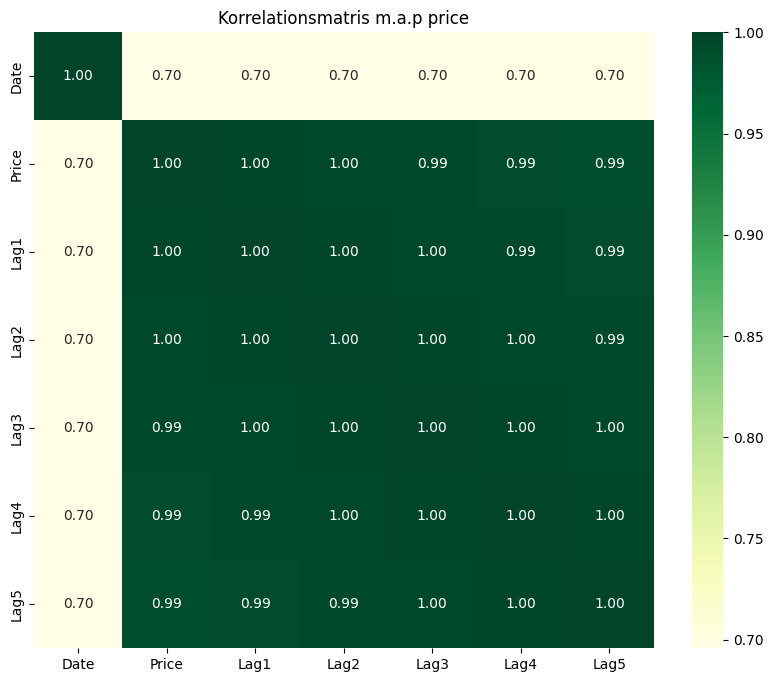

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Skapa en heatmap med korrelationsvärdena
plt.figure(figsize=(10, 8))
sns.heatmap(crypto_price_LAG.corr(), annot=True, cmap='YlGn', fmt=".2f")
plt.title('Korrelationsmatris m.a.p price')
plt.show()


### Logistisk regressionsmodell 

Nedan ska jag försöka anpassa en logistisk regressionsmodell för att förutsäga "Riktning(Direction)" med hjälp av Lag1 till Lag5. 

Nedan lägger jag först till en kolumn "Direction" som visar om priset har gått upp eller ner sedan tidigare dag. Sparar ner det nya datasettet i en ny csv.

In [128]:

# Läser in datasetet
df_with_direction = pd.read_csv("LAG_on_crypto_price_market_subset.csv")

# Skapar en kolumn "Direction" baserat på prisförändringen jämfört med föregående dag
df_with_direction['Direction'] = df_with_direction['Price'].diff().apply(lambda x: 'Up' if x > 0 else 'Down')

# Sparar den uppdaterade datan till en ny CSV-fil
df_with_direction.to_csv("LAG_on_crypto_price_market_subset_with directions.csv", index=False)


Skriver ut dom 5 första raderna i dataset. Ser nu att kolumnen "Direction" finns med.

In [129]:
df_with_direction.head()

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
0,2018-01-06,8583,8199.0,7959.0,7879.0,7155.0,6345.0,Down
1,2018-01-07,9267,8583.0,8199.0,7959.0,7879.0,7155.0,Up
2,2018-01-08,9723,9267.0,8583.0,8199.0,7959.0,7879.0,Up
3,2018-01-09,11216,9723.0,9267.0,8583.0,8199.0,7959.0,Up
4,2018-01-10,11023,11216.0,9723.0,9267.0,8583.0,8199.0,Down


In [130]:
print(df_with_direction.dtypes)

Date          object
Price          int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Direction     object
dtype: object


Funderar på om "Date" har någon korrelation som behöver tas med i beräkningen. "Date" kom inte med i .corr() då den ligger som ett object. Nedan celler inom markeringen 
#=====# provar jag att göra om "Date" till datatypen int64.

###===========================================###

In [131]:
import pandas as pd

# Läs in CSV-filen
df = pd.read_csv('LAG_on_crypto_price_market_subset_with directions.csv')

# Datumkolumnen heter 'Date'
df['Date'] = pd.to_datetime(df['Date'])

# Konverterar datumkolumnen till Unix-tidsstämplar som int64
df['Date'] = (df['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Visa DataFrame med Unix-tidsstämplar
print(df)


            Date  Price     Lag1     Lag2     Lag3     Lag4     Lag5 Direction
0     1515196800   8583   8199.0   7959.0   7879.0   7155.0   6345.0      Down
1     1515283200   9267   8583.0   8199.0   7959.0   7879.0   7155.0        Up
2     1515369600   9723   9267.0   8583.0   8199.0   7959.0   7879.0        Up
3     1515456000  11216   9723.0   9267.0   8583.0   8199.0   7959.0        Up
4     1515542400  11023  11216.0   9723.0   9267.0   8583.0   8199.0      Down
...          ...    ...      ...      ...      ...      ...      ...       ...
1815  1672099200  12867  12836.0  12863.0  12857.0  12744.0  12643.0        Up
1816  1672185600  12698  12867.0  12836.0  12863.0  12857.0  12744.0      Down
1817  1672272000  12438  12698.0  12867.0  12836.0  12863.0  12857.0      Down
1818  1672358400  12567  12438.0  12698.0  12867.0  12836.0  12863.0        Up
1819  1672444800  12503  12567.0  12438.0  12698.0  12867.0  12836.0      Down

[1820 rows x 8 columns]


In [132]:
df

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
0,1515196800,8583,8199.0,7959.0,7879.0,7155.0,6345.0,Down
1,1515283200,9267,8583.0,8199.0,7959.0,7879.0,7155.0,Up
2,1515369600,9723,9267.0,8583.0,8199.0,7959.0,7879.0,Up
3,1515456000,11216,9723.0,9267.0,8583.0,8199.0,7959.0,Up
4,1515542400,11023,11216.0,9723.0,9267.0,8583.0,8199.0,Down
...,...,...,...,...,...,...,...,...
1815,1672099200,12867,12836.0,12863.0,12857.0,12744.0,12643.0,Up
1816,1672185600,12698,12867.0,12836.0,12863.0,12857.0,12744.0,Down
1817,1672272000,12438,12698.0,12867.0,12836.0,12863.0,12857.0,Down
1818,1672358400,12567,12438.0,12698.0,12867.0,12836.0,12863.0,Up


Nedan kan ses att "Date" nu är av datatypen int64.

In [133]:
print(df.dtypes)

Date           int64
Price          int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Direction     object
dtype: object


När jag nu tar .corr() på datasettet "df" kommer "Date" med.

In [134]:
# Behöver lägga till (numeric_only=True) då "direction" kolumnen är en float.
df.corr(numeric_only=True)


,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5
Date,1.000000,0.695731,0.695750,0.695783,0.695832,0.695916,0.696048
Price,0.695731,1.000000,0.997979,0.996210,0.994364,0.992396,0.990308
Lag1,0.695750,0.997979,1.000000,0.997978,0.996210,0.994362,0.992389
Lag2,0.695783,0.996210,0.997978,1.000000,0.997978,0.996208,0.994356
Lag3,0.695832,0.994364,0.996210,0.997978,1.000000,0.997977,0.996203
Lag4,0.695916,0.992396,0.994362,0.996208,0.997977,1.000000,0.997976
Lag5,0.696048,0.990308,0.992389,0.994356,0.996203,0.997976,1.000000


Ovan kan ses att "Date" över Lag1 -Lag5 inte har så stor skillnad dessa emellan i värde på korrelation. Dom ligger mellan 0.695750 till 0.696048. Med tanke på att jag är lite tveksam till den höga korrelationen på nära 1 på Lag1 -Lag5 mot Price så kanske det här är mera rimligt. Svårt att veta.

###==========================================###

Går nu tillbaka och fortsätter utan "Date" med i korrelationen. Se nedan på "df_with_direction.corr()"

In [135]:
df_with_direction.corr(numeric_only=True)

,Price,Lag1,Lag2,Lag3,Lag4,Lag5
Price,1.000000,0.997979,0.996210,0.994364,0.992396,0.990308
Lag1,0.997979,1.000000,0.997978,0.996210,0.994362,0.992389
Lag2,0.996210,0.997978,1.000000,0.997978,0.996208,0.994356
Lag3,0.994364,0.996210,0.997978,1.000000,0.997977,0.996203
Lag4,0.992396,0.994362,0.996208,0.997977,1.000000,0.997976
Lag5,0.990308,0.992389,0.994356,0.996203,0.997976,1.000000


Funktionen sm.GLM() passar in i generaliserade linjära modeller, en klass av modeller som inkluderar logistisk regression. Alternativt anpassar funktionen sm.Logit() en logistisk regressionsmodell direkt. Syntaxen för sm.GLM() är liknande den för sm.OLS(), förutom att vi måste skicka med argumentet family=sm.families.Binomial() för att tala om för statsmodels att köra en logistisk regression istället för någon annan typ av generaliserad linjär modell.

I nästa steg kommer vi att anpassa en logistisk regressionsmodell för att förutsäga riktningen(Direction") genom att använda Lag1 till Lag5. Jag tar därför bort "Date" och "Direction" med .drop. 

In [136]:
allvars = df_with_direction.columns.drop(['Date', "Direction"])
print(allvars)
design = MS(allvars)
X = design.fit_transform(df_with_direction)
y = df_with_direction.Direction == 'Up'
glm = sm.GLM(y,
X,
family=sm.families.Binomial())
results = glm.fit()
summarize(results)

Index(['Price', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'], dtype='object')


/mnt/c/Users/aras/python_iths/AI_projects/aras_venv3.9/lib/python3.9/site-packages/ISLP/models/columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
/mnt/c/Users/aras/python_iths/AI_projects/aras_venv3.9/lib/python3.9/site-packages/ISLP/models/columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
/mnt/c/Users/aras/python_iths/AI_projects/aras_venv3.9/lib/python3.9/site-packages/ISLP/models/columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

,coef,std err,z,P>|z|
intercept,0.011800,0.199,0.059,0.953
Price,0.175900,0.016,11.027,0.000
Lag1,-0.176100,0.016,-10.994,0.000
Lag2,-0.000400,0.002,-0.237,0.813
Lag3,-0.000400,0.002,-0.244,0.807
Lag4,0.000052,0.002,0.033,0.974
Lag5,0.000800,0.001,0.823,0.411


Se ovan. Det minsta p-värdet kan ses i Price samt Lag1. Coefficienten är positiv (0.175900) för Price och negativ(-0.176100) för Lag1. Lag1 indikerar att om priset för Ethereum var positivt igår är det troligt att det blir negativt idag. Likväl ger ett värde på 0.175900 för "Price" att med en ökning av priset för Ethereum idag ökar sannolikheten för att priset kommer att vara positivt imorgon. 

Å ena sidan indikerar en positiv koefficient för "Price" att en ökning av priset för Ethereum idag förväntas öka sannolikheten för att priset kommer att vara positivt imorgon. Å andra sidan indikerar en negativ koefficient för "Lag1" att om priset för Ethereum var positivt igår, är det mindre troligt att priset kommer att vara positivt idag. Motsägelse!

In [137]:
results.params

intercept    0.011838
Price        0.175929
Lag1        -0.176060
Lag2        -0.000375
Lag3        -0.000383
Lag4         0.000052
Lag5         0.000825
dtype: float64

In [138]:
results.pvalues

intercept    9.526021e-01
Price        2.837912e-28
Lag1         4.065666e-28
Lag2         8.125986e-01
Lag3         8.072499e-01
Lag4         9.735440e-01
Lag5         4.107420e-01
dtype: float64

In [139]:
# Hämta p-värdena
p_values = results.pvalues

# Formatera p-värdena med 4 decimaler
formatted_p_values = p_values.apply(lambda x: "{:.4f}".format(x))

# Visa de formaterade p-värdena
print(formatted_p_values)


intercept    0.9526
Price        0.0000
Lag1         0.0000
Lag2         0.8126
Lag3         0.8072
Lag4         0.9735
Lag5         0.4107
dtype: object


Metoden predict(), nedan kan användas för att förutsäga sannolikheten att marknaden kommer att stiga, givet värden på prediktorerna. Denna metod returnerar förutsägelser på sannolikhetsskalan. Om ingen datamängd tillhandahålls till predict()-funktionen, beräknas sannolikheterna för träningsdatan som användes för att passa den logistiska regressionsmodellen. Liksom med linjär regression kan man skicka med ett valfritt exog-argument som är förenligt med en designmatris om så önskas. Skriver ut de första tio sannolikheterna.

In [140]:
probs = results.predict()
probs[:10]

/mnt/c/Users/aras/python_iths/AI_projects/aras_venv3.9/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       4.25376811e-016, 1.27905232e-109, 1.00000000e+000, 1.00000000e+000,
       2.36095333e-024, 5.74637404e-053])

För att göra en förutsägelse om marknaden kommer att gå upp eller ner på en specifik dag måste dessa förutsagda omvandla till sannolikheter till klassetiketter, "Up" eller "Down". De följande två kommandona skapar en vektor av klassförutsägelser baserat på om den förutsagda sannolikheten för en marknadsökning är större eller mindre än 0.5.

In [141]:
labels = np.array(['Down']*1820)
labels[probs >0.5] = "Up"

Funktionen confusion_table() från paketet ISLP summerar dessa tabellförutsägelser och visar hur många observationer som klassificerades korrekt eller inkorrekt. Funktionen confusion_table() tar som första argument de förutsagda etiketterna och som andra argument de sanna etiketterna.

In [142]:
confusion_table(labels, df_with_direction.Direction)

Truth,Down,Up
Predicted,,
Down,888,1
Up,5,926


På ovan matrix. Titta på diagonalvärderna. The diagonal elements of the confusion matrix indicate correct predictions. 888 för korrekta down samt 926 för korrekta up. Summa 888+926=1814

Funktionen np.mean() kan användas för att beräkna andelen dagar då förutsägelsen var korrekt, se nedan.

In [143]:
(888+926)/1820, np.mean(labels == df_with_direction.Direction)

(0.9967032967032967, 0.9967032967032967)

Enligt ovan resultat skulle modellen nästan vara 100%ig vilket inte känns rimlig. Eller? Det som inte känns rätt är att jag har använt samma data både för att testa och träna modellen. Det blir missledande. Jag har följt exemplet i boken "https://www.statlearning.com/" och där blir nästa steg blir just att ta ut en del av datan till att träna på och en annan del av datan att testa på. 

Nedan ville jag bara igen se att datan ser ok ut.

In [144]:
print(df_with_direction)

            Date  Price     Lag1     Lag2     Lag3     Lag4     Lag5 Direction
0     2018-01-06   8583   8199.0   7959.0   7879.0   7155.0   6345.0      Down
1     2018-01-07   9267   8583.0   8199.0   7959.0   7879.0   7155.0        Up
2     2018-01-08   9723   9267.0   8583.0   8199.0   7959.0   7879.0        Up
3     2018-01-09  11216   9723.0   9267.0   8583.0   8199.0   7959.0        Up
4     2018-01-10  11023  11216.0   9723.0   9267.0   8583.0   8199.0      Down
...          ...    ...      ...      ...      ...      ...      ...       ...
1815  2022-12-27  12867  12836.0  12863.0  12857.0  12744.0  12643.0        Up
1816  2022-12-28  12698  12867.0  12836.0  12863.0  12857.0  12744.0      Down
1817  2022-12-29  12438  12698.0  12867.0  12836.0  12863.0  12857.0      Down
1818  2022-12-30  12567  12438.0  12698.0  12867.0  12836.0  12863.0        Up
1819  2022-12-31  12503  12567.0  12438.0  12698.0  12867.0  12836.0      Down

[1820 rows x 8 columns]


Objektet train nedan är en vektor med 1820 element, vilket motsvarar observationerna i vår datamängd. Elementen i vektorn som motsvarar observationer som inträffade före 2022-11-01 är inställda som True, medan de som motsvarar observationer efter 2022-11-01 är inställda som False. Därför är train en boolesk matris, eftersom dess element är True och False. Booleska matriser kan användas för att erhålla en delmängd av raderna eller kolumnerna i en dataram genom att använda metoden loc.

In [145]:
train = (df_with_direction.Date < "2022-11-01")
df_train = df_with_direction.loc[train]
df_test = df_with_direction.loc[~train]
df_test.shape

(61, 8)

Vi kan se ovan att df_test, som är våra värden efter 2022-11-01 är 61 stycken i antal.

Skriver vi istället ut "train" ser vi samtliga booleska värden i datasettet. Vi ser att dom sista utskrivna värderna är "False" dvs dom ligger efter 2022-11-01.

In [146]:
train

0        True
1        True
2        True
3        True
4        True
        ...  
1815    False
1816    False
1817    False
1818    False
1819    False
Name: Date, Length: 1820, dtype: bool

Nedan ser vi hela train-datan som består av 1759 rader.

In [147]:
df_train

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
0,2018-01-06,8583,8199.0,7959.0,7879.0,7155.0,6345.0,Down
1,2018-01-07,9267,8583.0,8199.0,7959.0,7879.0,7155.0,Up
2,2018-01-08,9723,9267.0,8583.0,8199.0,7959.0,7879.0,Up
3,2018-01-09,11216,9723.0,9267.0,8583.0,8199.0,7959.0,Up
4,2018-01-10,11023,11216.0,9723.0,9267.0,8583.0,8199.0,Down
...,...,...,...,...,...,...,...,...
1754,2022-10-27,17013,16043.0,14972.0,15285.0,14699.0,14534.0,Up
1755,2022-10-28,16599,17013.0,16043.0,14972.0,15285.0,14699.0,Down
1756,2022-10-29,17024,16599.0,17013.0,16043.0,14972.0,15285.0,Up
1757,2022-10-30,17729,17024.0,16599.0,17013.0,16043.0,14972.0,Up


Och nedan hela testdatan, 61, rader.

In [148]:
df_test

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
1759,2022-11-01,17357,17459.0,17729.0,17024.0,16599.0,17013.0,Down
1760,2022-11-02,17417,17357.0,17459.0,17729.0,17024.0,16599.0,Up
1761,2022-11-03,16907,17417.0,17357.0,17459.0,17729.0,17024.0,Down
1762,2022-11-04,17138,16907.0,17417.0,17357.0,17459.0,17729.0,Up
1763,2022-11-05,18099,17138.0,16907.0,17417.0,17357.0,17459.0,Up
...,...,...,...,...,...,...,...,...
1815,2022-12-27,12867,12836.0,12863.0,12857.0,12744.0,12643.0,Up
1816,2022-12-28,12698,12867.0,12836.0,12863.0,12857.0,12744.0,Down
1817,2022-12-29,12438,12698.0,12867.0,12836.0,12863.0,12857.0,Down
1818,2022-12-30,12567,12438.0,12698.0,12867.0,12836.0,12863.0,Up



Nu anpassar vi en logistisk regressionsmodell endast med den delmängd av observationerna som motsvarar datum före 2022-11-01. Sedan erhåller vi förutsagda sannolikheter för att aktiemarknaden ska öka för varje dag i vår testmängd - det vill säga för dagarna efter 2022-11-01.

In [149]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

/mnt/c/Users/aras/python_iths/AI_projects/aras_venv3.9/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Vi har tränat och testat vår modell på två helt separata datamängder: träning utfördes endast med datum före 2022-11-01, och testning utfördes endast med datum under 2022-11-01.

In [150]:
X_train

,intercept,Price,Lag1,Lag2,Lag3,Lag4,Lag5
0,1.0,8583,8199.0,7959.0,7879.0,7155.0,6345.0
1,1.0,9267,8583.0,8199.0,7959.0,7879.0,7155.0
2,1.0,9723,9267.0,8583.0,8199.0,7959.0,7879.0
3,1.0,11216,9723.0,9267.0,8583.0,8199.0,7959.0
4,1.0,11023,11216.0,9723.0,9267.0,8583.0,8199.0
...,...,...,...,...,...,...,...
1754,1.0,17013,16043.0,14972.0,15285.0,14699.0,14534.0
1755,1.0,16599,17013.0,16043.0,14972.0,15285.0,14699.0
1756,1.0,17024,16599.0,17013.0,16043.0,14972.0,15285.0
1757,1.0,17729,17024.0,16599.0,17013.0,16043.0,14972.0


In [151]:
X_test

,intercept,Price,Lag1,Lag2,Lag3,Lag4,Lag5
1759,1.0,17357,17459.0,17729.0,17024.0,16599.0,17013.0
1760,1.0,17417,17357.0,17459.0,17729.0,17024.0,16599.0
1761,1.0,16907,17417.0,17357.0,17459.0,17729.0,17024.0
1762,1.0,17138,16907.0,17417.0,17357.0,17459.0,17729.0
1763,1.0,18099,17138.0,16907.0,17417.0,17357.0,17459.0
...,...,...,...,...,...,...,...
1815,1.0,12867,12836.0,12863.0,12857.0,12744.0,12643.0
1816,1.0,12698,12867.0,12836.0,12863.0,12857.0,12744.0
1817,1.0,12438,12698.0,12867.0,12836.0,12863.0,12857.0
1818,1.0,12567,12438.0,12698.0,12867.0,12836.0,12863.0


In [152]:
y_train

0       False
1        True
2        True
3        True
4       False
        ...  
1754     True
1755    False
1756     True
1757     True
1758    False
Name: Direction, Length: 1759, dtype: bool

In [153]:
y_test

1759    False
1760     True
1761    False
1762     True
1763     True
        ...  
1815     True
1816    False
1817    False
1818     True
1819    False
Name: Direction, Length: 61, dtype: bool

Slutligen jämför vi förutsägelserna för datum efter 2022-11-01 med de faktiska rörelserna på marknaden under den tidsperioden. Jag börjar med att spara test- och träningsetiketterna som varibeln "D" (kom ihåg att y_test är binär, "False" eller "True").

In [154]:
D = df_with_direction.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [155]:
print(D)

0       Down
1         Up
2         Up
3         Up
4       Down
        ... 
1815      Up
1816    Down
1817    Down
1818      Up
1819    Down
Name: Direction, Length: 1820, dtype: object


Jag sätter gränsvärdet för sannorlikheten till 50%.

In [156]:
labels = np.array(['Down']*61)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,34,0
Up,0,27


In [157]:
np.mean(labels == L_test), np.mean(labels != L_test)

(1.0, 0.0)

Ovan resultat känns helt orimligt, för bra helt enkelt. Jag väljer att stanna här för inlämning av projektet